## Introduction

The Food truck business is a fast-growing industry. It has been growing for years into today’s existing market segment. Although the restaurant industry has moved up at the growth rate of 2% yearly, the food truck industry has a huge 7.9% annual growth rate for the past 5 years. One of the main reasons for this growth is the low start-up cost of a food truck business which is approximately $50,000 to $100,000, with $250,000 to $500,000 expected annual revenue. In addition, the traditional food truck industry has provided other unique and creative opportunities for businesses.



My business idea is to set up a food truck in an appropriate locality in the New York city which would serve Indian food at reasonable cost. Appropriate location would include shopping malls and big marts where families spend most of their weekends. Grabbing a bite of tasty Indian food after long hours of tiresome shopping could make anybody’s day. Also, the craze for eating organic and healthy food has taken an emerging trend.  Healthy and reasonable Indian snacks could be the best option on people’s list.

## Data that will be used to solve the problem and the source of the data.



New York is the most populus city in the United States. The city contains 5 boroughs. The city has attracted tourists from all around the globe. The city not only has historical tourist locations but also rich and modern attractions such as shopping malls & parks.

The data which I shall be using to conduct my analysis would include locational data from Foursquare. The data would help me locate the areas where modern shopping centres are located. Analyzing the locational data around the shopping malls would help me evaluate the appropriate location for setting up my Indian food truck.

In such a way, I will be able to narrow down few locations before I commence the feasibility study of starting my business

## Running the code

## Importing various libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.1

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    scikit-learn-0.20.1        |   py36h22eb022_0         5.7 MB
    liblapack-3.8.0            |      11_openblas          10 KB  conda-forge
    liblapacke-3.8.0           |      11_openblas          10 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    libopenblas-0.3.6          |       h5a2b251_2         7.7 MB
    scipy-1.4.1                |   py36h921218d_0        18.9 MB  conda-forge
    lib

## Downloading New York Neighbourhood Data

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


## Loading the data

In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

## Creating a data frame

In [4]:
neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


## Exploring co-ordinates of New York

In [5]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


## Creating a map of New York city

In [6]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

## Extracting data from Foursquare

In [15]:
CLIENT_ID = '3H5Y5LXWNZ0EBEX1HCK4PWBJWR3CN1U23U4VK5GBR0VTFA3C' # your Foursquare ID
CLIENT_SECRET = 'J11HO1VLJLTGOKIWSZUBI1OOCZS1J2EKOF2DG032JNRG2VKL' # your Foursquare Secret
VERSION = '20180604' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 3H5Y5LXWNZ0EBEX1HCK4PWBJWR3CN1U23U4VK5GBR0VTFA3C
CLIENT_SECRET:J11HO1VLJLTGOKIWSZUBI1OOCZS1J2EKOF2DG032JNRG2VKL


In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&r0adius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

## Extracting venues

In [17]:
newyork_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

## Analyzing each neighbourhood

In [18]:
# one hot encoding
newyork_onehot = pd.get_dummies(newyork_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
newyork_onehot['Neighborhood'] = newyork_venues['Neighborhood'] 

# setting index to neighborhood
newyork_onehot.set_index('Neighborhood', inplace=True)
newyork_onehot.reset_index(inplace=True)

newyork_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Gym,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Hunan Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Island,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Kofte Place,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Modern Greek Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant

## Analyzing neighbourhoods with highest number of shopping malls and related locations

In [19]:
newyork_shopping = newyork_onehot[['Neighborhood','Shopping Mall','Shopping Plaza','Street Food Gathering','Supermarket','Plaza','Outlet Mall','Outlet Store','Supplement Shop','Warehouse Store']]
newyork_grouped = newyork_shopping.groupby('Neighborhood').sum(ascending=False)
newyork_grouped['Total'] =  newyork_grouped.sum (axis = 1)
newyork_grouped.head(25)

,Shopping Mall,Shopping Plaza,Street Food Gathering,Supermarket,Plaza,Outlet Mall,Outlet Store,Supplement Shop,Warehouse Store,Total
Neighborhood,,,,,,,,,,
Allerton,0,0,0,0,0,0,0,0,0,0
Annadale,0,0,0,0,0,0,0,0,1,1
Arden Heights,1,0,0,0,0,0,0,0,1,2
Arlington,1,0,0,1,0,0,0,0,0,2
Arrochar,0,0,0,2,0,0,0,0,0,2
Arverne,0,0,0,0,0,0,0,0,0,0
Astoria,0,0,0,0,1,0,0,0,0,1
Astoria Heights,0,0,0,1,0,0,0,0,0,1
Auburndale,0,0,0,1,0,0,0,0,0,1


## Importing plotting library to perform viualization

In [20]:
# using the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.1.1


In [27]:
newyork_grouped.sort_values("Total",ascending=False,axis=0,inplace=True)
newyork_grouped.head(5)


,Shopping Mall,Shopping Plaza,Street Food Gathering,Supermarket,Plaza,Outlet Mall,Outlet Store,Supplement Shop,Warehouse Store,Total
Neighborhood,,,,,,,,,,
New Lots,1,0,0,4,2,0,0,1,1,9
Eastchester,5,0,0,2,0,0,0,1,1,9
West Farms,1,0,0,4,2,0,0,1,0,8
Soundview,0,0,0,6,2,0,0,0,0,8
Bayswater,1,0,0,5,0,0,0,0,1,7


In [31]:
top_7=newyork_grouped.head(7)
top_7

,Shopping Mall,Shopping Plaza,Street Food Gathering,Supermarket,Plaza,Outlet Mall,Outlet Store,Supplement Shop,Warehouse Store,Total
Neighborhood,,,,,,,,,,
New Lots,1,0,0,4,2,0,0,1,1,9
Eastchester,5,0,0,2,0,0,0,1,1,9
West Farms,1,0,0,4,2,0,0,1,0,8
Soundview,0,0,0,6,2,0,0,0,0,8
Bayswater,1,0,0,5,0,0,0,0,1,7
Morrisania,0,0,0,5,0,0,0,2,0,7
City Line,0,0,0,7,0,0,0,0,0,7


## Plotting top 7 locations on the pie chart

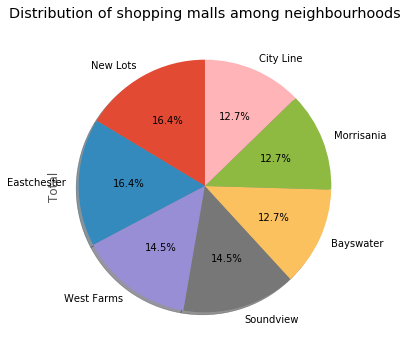

In [32]:
top_7['Total'].plot(kind='pie',
                            figsize=(5, 6),
                            autopct='%1.1f%%', # add in percentages
                            startangle=90,     # start angle 90° (Africa)
                            shadow=True,       # add shadow      
                            )

plt.title('Distribution of shopping malls among neighbourhoods')
plt.axis('equal') # Sets the pie chart to look like a circle.

plt.show()

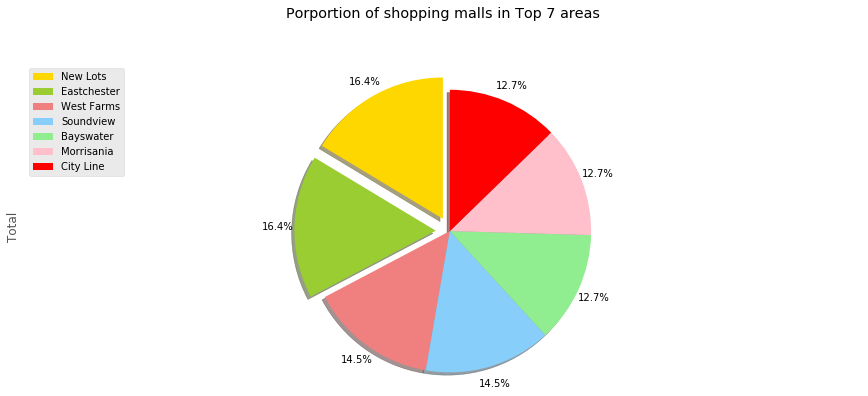

In [39]:
colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'pink','red']
explode_list = [0.1, 0.1, 0, 0, 0, 0,0] # ratio for each continent with which to offset each wedge.

top_7['Total'].plot(kind='pie',
                            figsize=(15, 6),
                            autopct='%1.1f%%', 
                            startangle=90,    
                            shadow=True,       
                            labels=None,         # turn off labels on pie chart
                            pctdistance=1.12,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                            colors=colors_list,  # add custom colors
                            explode=explode_list # 'explode' lowest 3 continents
                            )

# scale the title up by 12% to match pctdistance
plt.title('Porportion of shopping malls in Top 7 areas', y=1.12) 

plt.axis('equal') 

# add legend
plt.legend(labels=top_7.index, loc='upper left') 

plt.show()

## Methodology Section

The Methodology adopted was to visualize the top 7 locations to narrow the feasibility study to these areas. Narrowing down the analysis to top 7 locations would help me in conducting an in depth search on  these neighborhoods which include the popularity of malls in these areas, the existing food trucks if any, number of restaurants in these areas etc.

I decided to use the pie chart for the same and see the proportion of the required locations among the top 7 neighborhoods.


## Results


Top 7 location for further analysis are New Lots, East Chester, West Farms, Sound View, Bayswater, Morrisania and City Line

## Recommendations

After careful consideration, it seems that New Lots and East chester have the greatest proportion of required locations.On further observation and analysis of data set, we understand that East Chester has 5 shopping malls while New Lots has 4 super marts.

## Conclusion


Further analysis of East Chester and New Lots can be considered for our the set up of Food Truck. We will have to further conduct a feasibility study of each of these locations to understand other factors which need to considered before finalizing the business idea. Other factors could include popularity of malls, rental charges for setting up food trucks, electricity and other connection charges if any, regulatory approvals required if any